# MNIST Digit Recognizer Kaggle Challenge

The goal of the project is to discover what kind of technique will yield in the best result (the highest accuracy in this case) for the Kaggle challenge: [Digit Recognizer](https://www.kaggle.com/c/digit-recognizer/overview). I will be looking at the following two kinds of techniques, namely:

- Ensemble of multiple neural networks
- Creating more data (Data augmentation)

With both techniques, I will be trying to squeeze out the best accuracy possible without, hopefully, overfitting the model(s).

## Pre-requires
If you are planning to run this code and play with it, there are some steps required to setup your environment:
1. Make sure that you have a folder called `data` in the root of this project where the train and test.csv files are stored. The train and test files can be downloaded from this [link](https://www.kaggle.com/c/digit-recognizer/data)
2. Another folder that is required to have is the `models` folder in the root of the project. This folder is used to store all the trained models. 
3. Create a virtual environment and install all the requirements:
```
$ pip3 install virtualenv
$ virtualenv venv
$ source venv/bin/activate
$ pip3 install -r requirements.txt
```

## TL;DR

Results:
   
Model | Kaggle<br>Accuracy 
------|-----------------
CNN\* | 0.99271
Ensemble with MLP | 0.99342
Ensemble with averaging | 0.99457
Data augmentation | 0.99571
Data augmentation + Ensemble with averaging | 0.99585

\* The exact same one used for the [Doodle Draw project](https://github.com/jurjen96/doodle-draw) 

The best performing model was able to detect 88 images more than a single CNN (with no data augmentation). To put it in perspective, the test data contains 28.000 images of which 27.796 can be detected with a relatively simple CNN model. A way more complex and slower approach is able to correctly identify 27.884 images. Based on the result, I would recommend for this dataset to stick with the simple CNN if the purpose of the project is to create something simple and fast and use data augmentation if you want to create something a bit more robust.

## Ensemble
The idea behind ensemble is to have multiple neural networks working together to discuss with each other which digit they recognize, given an image of a digit. I will be using 4 different CNN's just to try out if 4 different CNN's can beat a single CNN. 


First import all the required libraries:

In [111]:
import numpy as np
import time
import pandas as pd
import tensorflow as tf
import keras
from keras.models import load_model
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D
from keras.layers import Dense, Flatten, Dropout, Activation, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from tqdm import tqdm

If you are planning to run and experiment with this code, it is advisable to set the `REBUILD_DATA` variable to `True` for the first run and for the following runs to `False`; to save some time building/creating data. 

In [4]:
REBUILD_DATA = True

The next cell will build all the data by dividing the dataset in a train-, validation- and test-set. The dataset can be obtained via this [link](https://www.kaggle.com/c/digit-recognizer/data).

In [101]:
def build_data(split_train_val):
    """
    From the train and test dataset, create the input and output sets
    for training, validation and testing. The test dataset is the 
    set from Kaggle where we have to provide the predictions for
    
    split_train_val: the percentage of the train.csv data that 
                    should be used for training and validation. 
                    1.0 will result in X_train containing all 
                    the entries of the train.csv file and 0.0
                    will result in that X_validation contains 
                    all the data.
    """
    print('Importing the datasets')
    
    # Importing the train and test datasets
    dataset_train = pd.read_csv('data/train.csv')
    dataset_test = pd.read_csv('data/test.csv')

    X_data = dataset_train.loc[:, 'pixel0':].values
    X_test = dataset_test.loc[:, 'pixel0':].values
    y_data = dataset_train.label.values

    print('Processing the dataset (Normalizing/ hot encoding)')
    # Hot encode the training label
    y_data = keras.utils.to_categorical(y_data, 10, 'float32')

    # Normalizing the data between 0.0 and 1.0
    X_data = X_data / 255.
    X_test = X_test / 255.
    
    # Splitting the dataset based on the split_train_val
    X_train = X_data[:int(len(X_data)*split_train_val)]
    X_val = X_data[int(len(X_data)*split_train_val):]

    y_train = y_data[:int(len(X_data)*split_train_val)]
    y_val = y_data[int(len(X_data)*split_train_val):]

    X_train = X_train.reshape(-1, 28, 28, 1)
    X_val = X_val.reshape(-1, 28, 28, 1)
    X_test = X_test.reshape(-1, 28, 28, 1)

    print('Saving the data')
    np.save('X_train', X_train)
    np.save('X_val', X_val)
    np.save('X_test', X_test)
    np.save('y_train', y_train)
    np.save('y_val', y_val)
    return X_train, y_train, X_val, y_val, X_test
    
if REBUILD_DATA:
    print('Building data')
    X_train, y_train, X_val, y_val, X_test = build_data(split_train_val=0.8)
else:
    print('Loading data')
    X_train = np.load('X_train.npy', allow_pickle=True)
    y_train = np.load('y_train.npy', allow_pickle=True)
    X_val = np.load('X_val.npy', allow_pickle=True)
    y_val = np.load('y_val.npy', allow_pickle=True)
    X_test = np.load('X_test.npy', allow_pickle=True)
    
print(f"Size X-train: {X_train.shape}")
print(f"Size X-validation: {X_val.shape}")

Building data
Importing the datasets
Processing the dataset (Normalizing/ hot encoding)
Saving the data
Size X-train: (33600, 28, 28, 1)
Size X-validation: (8400, 28, 28, 1)


Check how the dataset is distributed and if we should limit some of the classes to prevent overfitting. This could occur, for example, when you have 10.000 images of a 5 and only 100 images of a 3. The neural network will be trained with both images, but never seen images will most likely be identified as a 5 rather than a 3 since the neural network is more used to seeing 5 than 3. 

<BarContainer object of 10 artists>

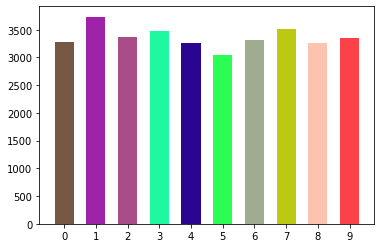

In [121]:
unique, cnts = np.unique(y_train, return_counts=True, axis=0)
# Convert from one hot encoding to real representation 0-9
unique_digits = [np.argmax(hot_encoded) for hot_encoded in unique]
# Generate some random colours for the bar chart
color = [c for c in np.random.rand(len(unique_digits),3)]

plt.xticks(np.arange(min(unique_digits), max(unique_digits)+1, 1.0))
plt.bar(unique_digits, height=cnts, width=0.6, color=color)

Overal, the dataset is distrubuted quite evenly so now further work has to be done here. 

Not a lot of thought has been put in selecting the different CNN models, I just checked what some of the more popular CNN's were and implemented them below. Only the `cnn` function is a CNN model that was created from scratch and build up experimentely. If you want to read more about the other CNN's, click [here](https://arxiv.org/pdf/1412.6806.pdf)

In [46]:
def convpool_cnn_c():
    model = Sequential()
    model.add(Conv2D(96, (3, 3), padding='same', input_shape=(28, 28, 1)))
    model.add(Activation('relu'))
    model.add(Conv2D(96, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(96, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=2))
    model.add(Conv2D(192, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(192, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(192, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=2))
    model.add(Conv2D(192, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(192, (1, 1)))
    model.add(Activation('relu'))
    model.add(Conv2D(10, (1, 1)))
    model.add(GlobalMaxPooling2D())
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return model

In [47]:
def all_cnn_c():
    model = Sequential()
    model.add(Conv2D(96, (3, 3), padding='same', input_shape=(28, 28, 1)))
    model.add(Activation('relu'))
    model.add(Conv2D(96, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(96, (3, 3), padding='same', strides=2))
    model.add(Activation('relu'))
    # model.add(MaxPooling2D(pool_size=(3, 3), strides=2))
    model.add(Conv2D(192, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(192, (3, 3), padding='same'))
    model.add(Activation('relu'))
    # model.add(MaxPooling2D(pool_size=(3, 3), strides=2))
    model.add(Conv2D(192, (3, 3), padding='same', strides=2))
    model.add(Activation('relu'))
    model.add(Conv2D(192, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(192, (1, 1)))
    model.add(Activation('relu'))
    model.add(Conv2D(10, (1, 1)))
    model.add(GlobalMaxPooling2D())
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return model

In [48]:
def cnn():
    # Pure CNN gives us 0.99271 with 50 epcos, batch_size=256, validation_split=0.2
    model = Sequential()

    model.add(Conv2D(16, (3, 3), padding='same', input_shape=(28, 28, 1)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(16, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(32, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(32, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.3))
    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.4))

    model.add(Flatten()) # Convert the 3D features (height, width, features) to 1D feature map
    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return model

In [49]:
def simple_cnn():
    model = Sequential()

    model.add(Conv2D(32, (3, 3), padding='same', input_shape=(28, 28, 1)))
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return model

After defining the models, it is time to train them with the training dataset defined above. Since we are planning to use ensemble, all the models will be stored in a list and trained sequentially on the same data.

In [50]:
names = ['simple_cnn', 'cnn', 'all_cnn_c', 'convpool_cnn_c']
models = [simple_cnn(), cnn(), all_cnn_c(), convpool_cnn_c()]
timestamp = int(time.time())

print("Training the models...")
for i, model in enumerate(models):
    print('Training: ' + names[i])
    model.fit(X_train, y_train,
                        epochs=40,
                        batch_size=128,
                        verbose=0)
    print('Saving model: ' + names[i])
    model.save('./models/' + names[i] + '_' + str(timestamp) + '.h5')

Training the models...
Training: simple_cnn
Saving model: simple_cnn
Training: cnn
Saving model: cnn
Training: all_cnn_c
Saving model: all_cnn_c
Training: convpool_cnn_c
Saving model: convpool_cnn_c


After training all the models, they can be simply loaded via the function defined below.

In [ ]:
def load_models():
    cnn = load_model('./models/m_cnn_1577020658.h5')
    convpool_cnn_c = load_model('./models/m_convpool_cnn_c_1577020658.h5')
    all_cnn_c = load_model('./models/m_all_cnn_c_1577020658.h5')
    simple_cnn = load_model('./models/m_simple_cnn_1577020658.h5')
    return [simple_cnn, cnn, all_cnn_c, convpool_cnn_c]
    
models = load_models()

I tried two different ensemble methods, namely:
- stacking
- averaging

With stacking, an extra model is added to the system that takes as input the combined predictions of the CNN's defined above and tries to learn which CNN should be more 'trusted' given a certain input image. The output of the extra model is the prediction of which digit is displayed in the image. For my experiment, I used a simple MLP and split the training data in 60% for the training of the CNN's and 40% for the CNN+MLP.

The other ensemble method, averaging, is a much simpler approach; which takes all the raw predicted outcomes and averages them and picks the highest value. 

In [52]:
def ensemble_mlp(nr_models):
    model = Sequential()

    model.add(Dense(40, activation='relu', input_dim=nr_models*10))
    model.add(Dropout(0.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.3))
    # model.add(Dense(32, activation='relu'))
    # model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

def get_stacked_inputs(models, X_val):
    print('Getting stacked inputs')
    stacked = np.array([])
    for model in models:
        pred = model.predict(X_val)
        if len(stacked):
            stacked = np.dstack((stacked, pred))
        else:
            stacked = pred

    stacked = stacked.reshape(-1, len(models) * 10)
    return stacked

# Ensemble model
ensemble_model = ensemble_mlp(len(models))

if REBUILD_DATA:
    X_stacked = get_stacked_inputs(models, X_val)
    np.save('X_stacked', X_stacked)
else:
    X_stacked = np.load('X_stacked.npy', allow_pickle=True)

Getting stacked inputs


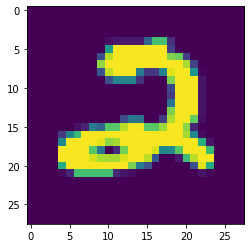

In [16]:
# Display the first image of the training set
plt.imshow(X=X_test[0].reshape((28,28)))
plt.show()

In [59]:
history = ensemble_model.fit(X_stacked, y_val,
                             epochs=30,
                             batch_size=128,
                             validation_split=0.1,
                             verbose=0)

ensemble_model.save('./models/ensemble_model_' + str(int(time.time())) + '.h5')


X_test_stacked = get_stacked_inputs(models, X_test)
np.save('X_test_stacked', X_test_stacked)

Getting stacked inputs


Predict and save the test set from the Kaggle challenge (Discussion about the results from both ensemble methods can be found below).

In [55]:
y_test = ensemble_model.predict(X_test_stacked)
y_test = np.argmax(y_test, axis=1)

df_submit = pd.DataFrame(y_test, columns=['Label'])
df_submit.insert(loc=0, column='ImageId', value=df_submit.index+1)

# Save the predicted outcomes
df_submit.to_csv('submit_mlp.csv', index=False)

The averaging (ensemble) approach is defined below. It predicts all the outcomes for the test.csv, averages them and picks the highest value 

In [56]:
def average(models):
    predicted = [model.predict(X_test) for model in models]

    summed = np.sum(predicted, axis=0)
    return np.argmax(summed, axis=1)

y_test = average(models)

df_submit = pd.DataFrame(y_test, columns=['Label'])
df_submit.insert(loc=0, column='ImageId', value=df_submit.index+1)

# Save the predicted outcomes
df_submit.to_csv('submit_avg.csv', index=False)

First I submitted the submit_mlp.csv file to the kaggle challenge and yielded an accuracy of 0.99300. Then I uploaded the ensemble model using average and got an accuracy of 0.99457. The lower result for the MLP approach could be explained by the fact that I only tried one ratio for splitting the train.csv dataset into training and validation, namely 0.6 -> 0.6 training and 0.4 validation. It could be that there is a better ratio for splitting the data. It could also be that the MLP model itself is not modeled correctly. I tried adding/removing some layers, but no improvement was registered. For this example, it shows that not always the fanciest approach is the best. A simple average approach is better than a multi layer perceptron (in this specific instance). 

## Data Augmentation
The other approach I will be looking at is using more (diverse) data. The current dataset contains 42.000 images we could train our models on. Coming from a previous project where I trained on a dataset of 600.000 images, 42.000 didn't sound like a lot of images. For that reason, I looked around and found something that is called data augmentation. It takes a single image out of the dataset and transforms it a little bit so that it looks like a new image. For example, an image can be shifted (horizontally and vertically), rotated, zoomed in/out and many more transformations can be applied to the image to create more data. To test out how data augmentation works, I used the script below from [machinelearningmaster](https://machinelearningmastery.com/how-to-configure-image-data-augmentation-when-training-deep-learning-neural-networks/) to see how it would affect the data:

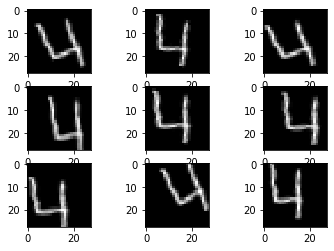

In [99]:
samples = X_train[3].reshape((-1,28,28,1))

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.15,  
    height_shift_range=0.15,
    zoom_range=[0.8,1.0]
)

# prepare iterator
it = datagen.flow(samples, batch_size=1)
# generate samples and plot
for i in range(9):
    # define subplot
    plt.subplot(330 + 1 + i)
    # generate batch of images
    batch = it.next()
    image = batch[0].astype('float32')
    # plot raw pixel data
    plt.imshow(image.reshape((28,28)), cmap=plt.get_cmap('gray'))

As can be seen, the digit is rotated and shifted alongside its axis every time the generator is called. This should be helpful to prevent overfitting and to generalize the trained model. To test out this assumption, the cell below creates an ImageDataGenerator and uses it to train a CNN model. With the implementation below, the trained model reached an accuracy of 0.99571 on the Kaggle challenge, a significant improvement over the ensemble method which at its best reached an accuracy of 0.99457. This shows the importance of diversity in data rather than having more complex CNN models combined via ensemble (in this specific instance).

In [115]:
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.15,  
    height_shift_range=0.15,
    zoom_range=[0.9,1.0]
)

datagen.fit(X_train)

batch_size = 128


model = cnn()

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size), 
                              steps_per_epoch=len(X_train) // batch_size,
                              validation_data=(X_val, y_val),
                              epochs=50,
                              verbose=2, 
                              callbacks=[learning_rate_reduction])

loss, acc = model.evaluate(X_val, y_val, verbose=0)
print(f'Model CNN accuracy: {acc} loss: {loss}')

timestamp = int(time.time())
model.save('./models/cnn_image_gen_' + str(timestamp) + '.h5')

Epoch 1/50
 - 8s - loss: 1.3971 - accuracy: 0.5597 - val_loss: 1.1935 - val_accuracy: 0.6229
Epoch 2/50
 - 6s - loss: 0.4211 - accuracy: 0.8733 - val_loss: 0.1693 - val_accuracy: 0.9505
Epoch 3/50
 - 7s - loss: 0.2543 - accuracy: 0.9265 - val_loss: 0.0711 - val_accuracy: 0.9787
Epoch 4/50
 - 7s - loss: 0.1819 - accuracy: 0.9490 - val_loss: 0.0772 - val_accuracy: 0.9768
Epoch 5/50
 - 7s - loss: 0.1452 - accuracy: 0.9572 - val_loss: 0.0532 - val_accuracy: 0.9825
Epoch 6/50
 - 7s - loss: 0.1262 - accuracy: 0.9654 - val_loss: 0.0474 - val_accuracy: 0.9852
Epoch 7/50
 - 7s - loss: 0.1181 - accuracy: 0.9666 - val_loss: 0.0410 - val_accuracy: 0.9879
Epoch 8/50
 - 6s - loss: 0.0984 - accuracy: 0.9724 - val_loss: 0.0361 - val_accuracy: 0.9888
Epoch 9/50
 - 6s - loss: 0.0915 - accuracy: 0.9747 - val_loss: 0.0335 - val_accuracy: 0.9888
Epoch 10/50
 - 6s - loss: 0.0894 - accuracy: 0.9756 - val_loss: 0.0444 - val_accuracy: 0.9858
Epoch 11/50
 - 6s - loss: 0.0872 - accuracy: 0.9748 - val_loss: 0.030

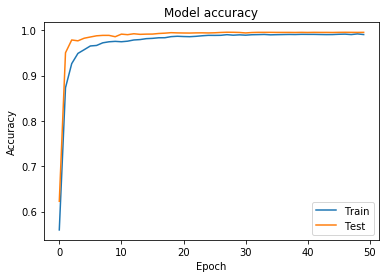

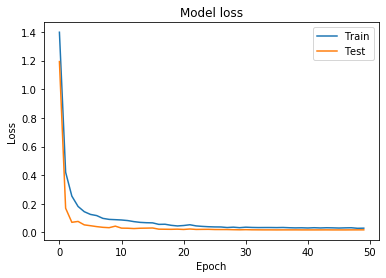

In [116]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='lower right')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [117]:
y_test = model.predict(X_test)
y_test = np.argmax(y_test, axis=1)

df_submit = pd.DataFrame(y_test, columns=['Label'])
df_submit.insert(loc=0, column='ImageId', value=df_submit.index+1)

# Save the predicted outcomes
df_submit.to_csv('submit_cnn.csv', index=False)

## Data augmentation + ensemble

Just for fun, I also tried combining both methods into one solution. The cells below train 4 different CNN models using the same technique as described for the data augmentation implementation together with the method of averaging all the predicted outcomes to get the final predicted digit. The end result is an accuracy of 0.99585 on the Kaggle challenge, an improvement of 0.00014 (\~4 images) compared to using only data augmentation and 0.00128 (\~36 images) compared to using only ensemble. The goal of the project was to squeeze out the last bit of accuracy out of the trained models. With an accuracy of 0.99585, the trained models have reached the top 16% (22/12/2019) of the Kaggle .  

In [118]:
names = ['simple_cnn', 'cnn', 'all_cnn_c', 'convpool_cnn_c']
models = [simple_cnn(), cnn(), all_cnn_c(), convpool_cnn_c()]
timestamp = int(time.time())

print("Training the models...")
for i, model in enumerate(models):
    print('Training: ' + names[i])
    model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size), 
                              steps_per_epoch=len(X_train) // batch_size,
                              validation_data=(X_val, y_val),
                              epochs=50,
                              verbose=2, 
                              callbacks=[learning_rate_reduction])

    print('Saving model: ' + names[i])
    model.save('./models/datagen_' + names[i] + '_' + str(timestamp) + '.h5')

Training the models...
Training: simple_cnn
Epoch 1/50
 - 6s - loss: 0.7628 - accuracy: 0.7495 - val_loss: 0.1346 - val_accuracy: 0.9627
Epoch 2/50
 - 6s - loss: 0.3253 - accuracy: 0.9011 - val_loss: 0.0968 - val_accuracy: 0.9707
Epoch 3/50
 - 6s - loss: 0.2494 - accuracy: 0.9235 - val_loss: 0.0669 - val_accuracy: 0.9798
Epoch 4/50
 - 6s - loss: 0.2127 - accuracy: 0.9349 - val_loss: 0.0613 - val_accuracy: 0.9806
Epoch 5/50
 - 6s - loss: 0.1950 - accuracy: 0.9412 - val_loss: 0.0635 - val_accuracy: 0.9794
Epoch 6/50
 - 6s - loss: 0.1693 - accuracy: 0.9474 - val_loss: 0.0579 - val_accuracy: 0.9804
Epoch 7/50
 - 6s - loss: 0.1606 - accuracy: 0.9526 - val_loss: 0.0560 - val_accuracy: 0.9831
Epoch 8/50
 - 6s - loss: 0.1539 - accuracy: 0.9537 - val_loss: 0.0482 - val_accuracy: 0.9844
Epoch 9/50
 - 6s - loss: 0.1423 - accuracy: 0.9569 - val_loss: 0.0488 - val_accuracy: 0.9833
Epoch 10/50
 - 6s - loss: 0.1412 - accuracy: 0.9569 - val_loss: 0.0451 - val_accuracy: 0.9858
Epoch 11/50
 - 6s - loss:

Epoch 29/50
 - 6s - loss: 0.0371 - accuracy: 0.9895 - val_loss: 0.0191 - val_accuracy: 0.9943

Epoch 00029: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
Epoch 30/50
 - 7s - loss: 0.0365 - accuracy: 0.9906 - val_loss: 0.0200 - val_accuracy: 0.9943
Epoch 31/50
 - 6s - loss: 0.0364 - accuracy: 0.9894 - val_loss: 0.0199 - val_accuracy: 0.9944
Epoch 32/50
 - 6s - loss: 0.0339 - accuracy: 0.9898 - val_loss: 0.0198 - val_accuracy: 0.9944

Epoch 00032: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.
Epoch 33/50
 - 6s - loss: 0.0349 - accuracy: 0.9907 - val_loss: 0.0199 - val_accuracy: 0.9943
Epoch 34/50
 - 6s - loss: 0.0350 - accuracy: 0.9901 - val_loss: 0.0198 - val_accuracy: 0.9944
Epoch 35/50
 - 7s - loss: 0.0348 - accuracy: 0.9898 - val_loss: 0.0198 - val_accuracy: 0.9945

Epoch 00035: ReduceLROnPlateau reducing learning rate to 1e-05.
Epoch 36/50
 - 6s - loss: 0.0367 - accuracy: 0.9902 - val_loss: 0.0195 - val_accuracy: 0.9944
Epoch 37/50
 - 7s - 


Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 7/50
 - 19s - loss: 0.0255 - accuracy: 0.9920 - val_loss: 0.0371 - val_accuracy: 0.9904
Epoch 8/50
 - 19s - loss: 0.0217 - accuracy: 0.9932 - val_loss: 0.0268 - val_accuracy: 0.9933
Epoch 9/50
 - 19s - loss: 0.0200 - accuracy: 0.9937 - val_loss: 0.0403 - val_accuracy: 0.9911
Epoch 10/50
 - 19s - loss: 0.0188 - accuracy: 0.9941 - val_loss: 0.0323 - val_accuracy: 0.9932
Epoch 11/50
 - 19s - loss: 0.0194 - accuracy: 0.9938 - val_loss: 0.0327 - val_accuracy: 0.9905

Epoch 00011: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 12/50
 - 19s - loss: 0.0129 - accuracy: 0.9960 - val_loss: 0.0267 - val_accuracy: 0.9939
Epoch 13/50
 - 19s - loss: 0.0099 - accuracy: 0.9971 - val_loss: 0.0257 - val_accuracy: 0.9938
Epoch 14/50
 - 19s - loss: 0.0103 - accuracy: 0.9969 - val_loss: 0.0287 - val_accuracy: 0.9936
Epoch 15/50
 - 19s - loss: 0.0096 - accuracy: 0.9970 - val_loss: 0.0267 - val_acc

In [119]:
def average(models):
    predicted = [model.predict(X_test) for model in models]

    summed = np.sum(predicted, axis=0)
    return np.argmax(summed, axis=1)

y_test = average(models)

df_submit = pd.DataFrame(y_test, columns=['Label'])
df_submit.insert(loc=0, column='ImageId', value=df_submit.index+1)

# Save the predicted outcomes
df_submit.to_csv('submit_datagen_avg.csv', index=False)